In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np

import random
import torch
import torch.nn as nn
from transformers import XLNetTokenizer, XLNetConfig
from transformers import modeling_xlnet, modeling_bart
from transformers.testing_utils import require_multigpu, require_torch, slow, torch_device

In [2]:
device = torch_device
torch_device

'cpu'

In [3]:
model_name = "xlnet-base-cased"

In [4]:
tokenizer = XLNetTokenizer.from_pretrained(model_name)

In [5]:
from transformers import MarianMTModel, MarianTokenizer
encoder_model_name = 'Helsinki-NLP/opus-mt-ROMANCE-en'
encoder_tokenizer = MarianTokenizer.from_pretrained(encoder_model_name)

In [6]:
encoder_model = MarianMTModel.from_pretrained(encoder_model_name).to(device)

In [7]:
def encode_L2(src):
    """
    Return the encoder hidden states and the padding mask (1 if the token is padding)"""
    batch = encoder_tokenizer.prepare_translation_batch([src]).to(device)
    with torch.no_grad():
        return dict(
            encoder_hidden_states=encoder_model.get_encoder()(**batch).last_hidden_state,
            padding_mask=batch['attention_mask'].eq(0) # invert the attention mask, which is 1 if we *should* include this token.
        )
encoder_output = encode_L2("Buenos días")
encoder_output

{'encoder_hidden_states': tensor([[[-0.1111, -0.0358, -0.3962,  ..., -0.2749,  0.2238,  0.2691],
          [-0.1629,  0.0071, -0.1031,  ..., -0.0354, -0.0248, -0.1916],
          [-0.0050, -0.0080, -0.0393,  ..., -0.1553, -0.0402,  0.1821]]]),
 'padding_mask': tensor([[False, False, False]])}

In [8]:
encoder_tokenizer.prepare_translation_batch(["Buenos días.", "1"])

{'input_ids': tensor([[ 9653,  2851,     3,     0],
        [  143,     0, 65000, 65000]]), 'attention_mask': tensor([[1, 1, 1, 1],
        [1, 1, 0, 0]])}

# Notes on paper and implementation

## Two-stream attention 

* `g` represents the **query**: it gets to look at all the prior words and the current desired position embedding, but *not* the content that's there.
* `h` represents the **content**: it gets everything that *g* does but also the content that's there.

# Define a custom XLNet that adds attention to encoder inputs.

Thanks to the wonders of inheritance, I can reuse most of the existing code even though it wasn't designed this way. Except for the main model `forward` methods...

In [9]:
class XLDecoderConfig(XLNetConfig):
    def __init__(
        self,
        encoder_dim=None,
        cross_attention_heads=12,
        cross_attention_dropout=.1,
        **kw
    ):
        super().__init__(**kw)
        self.encoder_dim = encoder_dim
        self.cross_attention_heads = cross_attention_heads
        self.cross_attention_dropout = cross_attention_dropout
        

In [10]:
class XLDecoderLayer(modeling_xlnet.XLNetLayer):
    def __init__(self, config):
        super().__init__(config)
        embed_dim = config.d_model

        self.encoder_attn = modeling_bart.SelfAttention(
            embed_dim,
            config.cross_attention_heads,
            dropout=config.cross_attention_dropout,
            encoder_decoder_attention=True,
        )
        self.encoder_attn_layer_norm = nn.LayerNorm(embed_dim)
        
    def forward(
        self,
        output_h,
        output_g,
        attn_mask_h,
        attn_mask_g,
        r,
        seg_mat,
        mems=None,
        target_mapping=None,
        head_mask=None,
        output_attentions=False,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
    ):
        # Run masked relative attention on target.
        outputs = self.rel_attn(
            output_h,
            output_g,
            attn_mask_h,
            attn_mask_g,
            r,
            seg_mat,
            mems=mems,
            target_mapping=target_mapping,
            head_mask=head_mask,
            output_attentions=output_attentions,
        )
        output_h, output_g = outputs[:2]

        # Cross attention, based on modeling_bart. Note: Some things about modeling_t5 seem clearer; maybe use that?
        # Need a function because we want to do the same thing on both streams.
        def cross_attention(x):
            # The attention module only outputs the attention values.
            # It does *not* add in `x`.
            attn_out, _ = self.encoder_attn(
                query=x,
                key=encoder_hidden_states,
                    key_padding_mask=encoder_attention_mask,
                layer_state=None # ignore this optimization for now.
            )
            return self.encoder_attn_layer_norm(
                x + self.dropout(attn_out))
        
        # If finetuning on another task, the query stream is dropped. We're not doing this now, but I'll leave the logic...
        if output_g is not None:
            output_g = cross_attention(output_g)
            output_g = self.ff(output_g)
        output_h = cross_attention(output_h)
        output_h = self.ff(output_h)

        outputs = (output_h, output_g) + outputs[2:]  # The additional output includes attention information; thread it back in.
        return outputs

In [38]:
class XLDecoderModel(modeling_xlnet.XLNetModel):
    def __init__(self, config):
        # This does one extra step of initialization that we're about to override...
        super().__init__(config)
        # here. Just use XLDecoderLayer instead.
        self.layer = nn.ModuleList([XLDecoderLayer(config) for _ in range(config.n_layer)])
        self.encoder_to_decoder = nn.Linear(config.encoder_dim, config.d_model)
        self.init_weights()
    
    # Lots of copy-paste, but gotta thread encoder data through here :(
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        mems=None,
        perm_mask=None,
        target_mapping=None,
        token_type_ids=None,
        input_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        inputs_embeds=None,
        use_cache=True,
        output_attentions=None,
        output_hidden_states=None,
        return_tuple=None,
    ):
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_tuple = return_tuple if return_tuple is not None else self.config.use_return_tuple

        # the original code for XLNet uses shapes [len, bsz] with the batch dimension at the end
        # but we want a unified interface in the library with the batch size on the first dimension
        # so we move here the first dimension (batch) to the end
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_ids = input_ids.transpose(0, 1).contiguous()
            qlen, bsz = input_ids.shape[0], input_ids.shape[1]
        elif inputs_embeds is not None:
            inputs_embeds = inputs_embeds.transpose(0, 1).contiguous()
            qlen, bsz = inputs_embeds.shape[0], inputs_embeds.shape[1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        token_type_ids = token_type_ids.transpose(0, 1).contiguous() if token_type_ids is not None else None
        input_mask = input_mask.transpose(0, 1).contiguous() if input_mask is not None else None
        attention_mask = attention_mask.transpose(0, 1).contiguous() if attention_mask is not None else None
        perm_mask = perm_mask.permute(1, 2, 0).contiguous() if perm_mask is not None else None
        target_mapping = target_mapping.permute(1, 2, 0).contiguous() if target_mapping is not None else None

        mlen = mems[0].shape[0] if mems is not None and mems[0] is not None else 0
        klen = mlen + qlen

        dtype_float = self.dtype
        device = self.device

        # Attention mask
        # causal attention mask
        if self.attn_type == "uni":
            attn_mask = self.create_mask(qlen, mlen)
            attn_mask = attn_mask[:, :, None, None]
        elif self.attn_type == "bi":
            attn_mask = None
        else:
            raise ValueError("Unsupported attention type: {}".format(self.attn_type))

        # data mask: input mask & perm mask
        assert input_mask is None or attention_mask is None, "You can only use one of input_mask (uses 1 for padding) "
        "or attention_mask (uses 0 for padding, added for compatbility with BERT). Please choose one."
        if input_mask is None and attention_mask is not None:
            input_mask = 1.0 - attention_mask
        if input_mask is not None and perm_mask is not None:
            data_mask = input_mask[None] + perm_mask
        elif input_mask is not None and perm_mask is None:
            data_mask = input_mask[None]
        elif input_mask is None and perm_mask is not None:
            data_mask = perm_mask
        else:
            data_mask = None

        if data_mask is not None:
            # all mems can be attended to
            if mlen > 0:
                mems_mask = torch.zeros([data_mask.shape[0], mlen, bsz]).to(data_mask)
                data_mask = torch.cat([mems_mask, data_mask], dim=1)
            if attn_mask is None:
                attn_mask = data_mask[:, :, :, None]
            else:
                attn_mask += data_mask[:, :, :, None]

        if attn_mask is not None:
            attn_mask = (attn_mask > 0).to(dtype_float)

        if attn_mask is not None:
            non_tgt_mask = -torch.eye(qlen).to(attn_mask)
            if mlen > 0:
                non_tgt_mask = torch.cat([torch.zeros([qlen, mlen]).to(attn_mask), non_tgt_mask], dim=-1)
            non_tgt_mask = ((attn_mask + non_tgt_mask[:, :, None, None]) > 0).to(attn_mask)
        else:
            non_tgt_mask = None

        # Word embeddings and prepare h & g hidden states
        if inputs_embeds is not None:
            word_emb_k = inputs_embeds
        else:
            word_emb_k = self.word_embedding(input_ids)
        output_h = self.dropout(word_emb_k)
        if target_mapping is not None:
            word_emb_q = self.mask_emb.expand(target_mapping.shape[0], bsz, -1)
            # else:  # We removed the inp_q input which was same as target mapping
            #     inp_q_ext = inp_q[:, :, None]
            #     word_emb_q = inp_q_ext * self.mask_emb + (1 - inp_q_ext) * word_emb_k
            output_g = self.dropout(word_emb_q)
        else:
            output_g = None

        # Segment embedding
        if token_type_ids is not None:
            # Convert `token_type_ids` to one-hot `seg_mat`
            if mlen > 0:
                mem_pad = torch.zeros([mlen, bsz], dtype=torch.long, device=device)
                cat_ids = torch.cat([mem_pad, token_type_ids], dim=0)
            else:
                cat_ids = token_type_ids

            # `1` indicates not in the same segment [qlen x klen x bsz]
            seg_mat = (token_type_ids[:, None] != cat_ids[None, :]).long()
            seg_mat = F.one_hot(seg_mat, num_classes=2).to(dtype_float)
        else:
            seg_mat = None

        # Positional encoding
        pos_emb = self.relative_positional_encoding(qlen, klen, bsz=bsz)
        pos_emb = self.dropout(pos_emb)

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads] (a head_mask for each layer)
        # and head_mask is converted to shape [num_hidden_layers x qlen x klen x bsz x n_head]
        if head_mask is not None:
            if head_mask.dim() == 1:
                head_mask = head_mask.unsqueeze(0).unsqueeze(0).unsqueeze(0).unsqueeze(0)
                head_mask = head_mask.expand(self.n_layer, -1, -1, -1, -1)
            elif head_mask.dim() == 2:
                head_mask = head_mask.unsqueeze(1).unsqueeze(1).unsqueeze(1)
            head_mask = head_mask.to(
                dtype=next(self.parameters()).dtype
            )  # switch to fload if need + fp16 compatibility
        else:
            head_mask = [None] * self.n_layer

            
        # transform encoder data.
        encoder_hidden_states = self.encoder_to_decoder(encoder_hidden_states)

        new_mems = ()
        if mems is None:
            mems = [None] * len(self.layer)

        attentions = [] if output_attentions else None
        hidden_states = [] if output_hidden_states else None
        for i, layer_module in enumerate(self.layer):
            if self.mem_len is not None and self.mem_len > 0 and use_cache is True:
                # cache new mems
                new_mems = new_mems + (self.cache_mem(output_h, mems[i]),)
            if output_hidden_states:
                hidden_states.append((output_h, output_g) if output_g is not None else output_h)

            outputs = layer_module(
                output_h,
                output_g,
                attn_mask_h=non_tgt_mask,
                attn_mask_g=attn_mask,
                r=pos_emb,
                seg_mat=seg_mat,
                mems=mems[i],
                target_mapping=target_mapping,
                head_mask=head_mask[i],
                output_attentions=output_attentions,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
            )
            output_h, output_g = outputs[:2]
            if output_attentions:
                attentions.append(outputs[2])

        # Add last hidden state
        if output_hidden_states:
            hidden_states.append((output_h, output_g) if output_g is not None else output_h)

        output = self.dropout(output_g if output_g is not None else output_h)

        # Prepare outputs, we transpose back here to shape [bsz, len, hidden_dim] (cf. beginning of forward() method)
        output = output.permute(1, 0, 2).contiguous()

        # TODO Teven: fix this test to only use use_cache.
        if not (self.mem_len is not None and self.mem_len > 0 and use_cache is True):
            new_mems = None

        if output_hidden_states:
            if output_g is not None:
                hidden_states = tuple(h.permute(1, 0, 2).contiguous() for hs in hidden_states for h in hs)
            else:
                hidden_states = tuple(hs.permute(1, 0, 2).contiguous() for hs in hidden_states)

        if output_attentions:
            if target_mapping is not None:
                # when target_mapping is provided, there are 2-tuple of attentions
                attentions = tuple(
                    tuple(att_stream.permute(2, 3, 0, 1).contiguous() for att_stream in t) for t in attentions
                )
            else:
                attentions = tuple(t.permute(2, 3, 0, 1).contiguous() for t in attentions)

        if return_tuple:
            return tuple(v for v in [output, new_mems, hidden_states, attentions] if v is not None)

        return modeling_xlnet.XLNetModelOutput(
            last_hidden_state=output, mems=new_mems, hidden_states=hidden_states, attentions=attentions
        )



In [52]:
class XLDecoderLMHeadModel(modeling_xlnet.XLNetLMHeadModel):
    def __init__(self, config):
        super().__init__(config)
        self.transformer = XLDecoderModel(config)
        self.init_weights()

    # Yucky copy-paste again.
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        mems=None,
        perm_mask=None,
        target_mapping=None,
        token_type_ids=None,
        input_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        use_cache=True,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        return_tuple=None,
    ):
        return_tuple = return_tuple if return_tuple is not None else self.config.use_return_tuple

        transformer_outputs = self.transformer(
            input_ids,
            attention_mask=attention_mask,
            mems=mems,
            perm_mask=perm_mask,
            target_mapping=target_mapping,
            token_type_ids=token_type_ids,
            input_mask=input_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_tuple=return_tuple,
        )

        logits = self.lm_loss(transformer_outputs[0])

        loss = None
        if labels is not None:
            # Flatten the tokens
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))

        if return_tuple:
            output = (logits,) + transformer_outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return modeling_xlnet.XLNetLMHeadModelOutput(
            loss=loss,
            logits=logits,
            mems=transformer_outputs.mems,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
        )


In [53]:
model_config = XLDecoderConfig.from_pretrained(model_name, mem_len=1024, encoder_dim=encoder_model.config.d_model)

In [54]:
model_config.mem_len

1024

In [55]:
model_config.use_cache

True

In [56]:
model = XLDecoderLMHeadModel(model_config)

# Masked inputs get no gradient

Note that [input and output embedding weights are tied](https://github.com/huggingface/transformers/blob/015dc51fe35f758b70a3066298dff6ae917c11ba/src/transformers/modeling_utils.py#L351). So just checking the word embedding gradient doesn't suffice if it's a predicted output. So... Untie the weights.

In [57]:
lm_loss_weight = torch.zeros_like(model.transformer.word_embedding.weight)
lm_loss_weight.copy_(model.transformer.word_embedding.weight)
model.lm_loss.weight = torch.nn.Parameter(lm_loss_weight)
assert model.lm_loss.weight is not model.transformer.word_embedding.weight
assert torch.allclose(model.lm_loss.weight, model.transformer.word_embedding.weight)

In [58]:
text = "Hello, my dog is very cute"
tok_idx_from_end = 4

In [59]:
input_ids = tokenizer.encode(text, add_special_tokens=False, return_tensors='pt').to(torch_device)
n_tokens = input_ids.shape[1]
idx_to_predict = n_tokens - tok_idx_from_end
tokenizer.convert_ids_to_tokens(input_ids[0, idx_to_predict].item())

'▁dog'

Here's how we'd define a `labels` to calculate a loss.

In [60]:
labels = input_ids[:, idx_to_predict].unsqueeze(0)
labels.shape

torch.Size([1, 1])

Create the "permutation mask": which tokens does each token get to look at when making the prediction?

It's `batch_size` by `src_token` by `tgt_token`. Element `b, src, tgt` is `0` if `tgt` gets to see `src` in batch sample `b`, `1` otherwise.

In [61]:
perm_mask = torch.zeros((1, n_tokens, n_tokens), dtype=torch.float, device=device)
# Mask the token to predict.
perm_mask[:, :, idx_to_predict] = 1.0

# Mask the one after it too, just to illustrate.
perm_mask[:, :, idx_to_predict+1] = 1.0
perm_mask

tensor([[[0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0.]]])

Create the "target mapping", which is `batch_size` x `num_targets` x `seq_length`. Each target should have a `1` for one of the sequence elements, corresponding to which token to try to predict.

In [62]:
target_mapping = torch.zeros((1, 1, input_ids.shape[1]), dtype=torch.float, device=device)  # Shape [1, 1, seq_length] => let's predict one token
target_mapping[0, 0, idx_to_predict] = 1.0  # Our first (and only) prediction
target_mapping

tensor([[[0., 0., 0., 0., 1., 0., 0., 0.]]])

Define initially empty memory.

In [63]:
mems = tuple([torch.zeros(0, 1, model.config.d_model) for _ in range(model.config.n_layer)])

Now call the model. It returns the loss and next token logits.

In [70]:
model.zero_grad()
outputs = model(
    input_ids,
    perm_mask=perm_mask, target_mapping=target_mapping,
    labels=labels,
    output_attentions=True, mems=mems,
    encoder_hidden_states=encoder_output['encoder_hidden_states'],
    encoder_attention_mask=encoder_output['padding_mask']
)
outputs.loss

tensor(9.8804, grad_fn=<NllLossBackward>)

Now run backward and ensure that neither masked token gets any update.

In [71]:
outputs.loss.backward()

(array([3.1994e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([0.       , 0.7647348, 1.5294696, 2.2942045, 3.0589392, 3.823674 ,
        4.588409 , 5.3531437, 6.1178784, 6.882613 , 7.647348 ],
       dtype=float32),
 <a list of 10 Patch objects>)

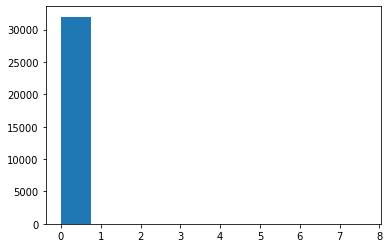

In [72]:
gradient_mags_by_word = np.linalg.norm(model.transformer.word_embedding.weight.grad.numpy(), axis=1)
plt.hist(gradient_mags_by_word)

In [73]:
input_ids[0].tolist()

[17, 11368, 19, 94, 2288, 27, 172, 10920]

In [74]:
gradient_mags_by_word[input_ids[0].tolist()]

array([7.0816526, 7.117165 , 7.647348 , 7.400329 , 0.       , 0.       ,
       7.544651 , 7.1951604], dtype=float32)

In [75]:
assert gradient_mags_by_word[input_ids[0, idx_to_predict]] == 0.

In [76]:
assert gradient_mags_by_word[input_ids[0, idx_to_predict - 1]] > 1

In [77]:
model_config.d_model

768

`mems` is a tuple of memory states per layer. Each seems to be shape `len` x `batch`? x `config.d_model`

In [78]:
outputs.mems[0].shape

torch.Size([8, 1, 768])

# Source attention does get gradient

In [83]:
assert model.transformer.encoder_to_decoder.weight.grad.norm() > 0.1

In [87]:
assert model.transformer.layer[0].encoder_attn.k_proj.weight.grad.norm() > 1e-2

In [89]:
model.transformer.layer[0].encoder_attn

SelfAttention(
  (k_proj): Linear(in_features=768, out_features=768, bias=True)
  (v_proj): Linear(in_features=768, out_features=768, bias=True)
  (q_proj): Linear(in_features=768, out_features=768, bias=True)
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
)

In [88]:
model.transformer.layer[0].encoder_attn.k_proj.weight.grad.norm()

tensor(0.0138)

In [90]:
model.transformer.layer[0].encoder_attn.v_proj.weight.grad.norm()

tensor(1.5781)

In [91]:
model.transformer.layer[0].encoder_attn.q_proj.weight.grad.norm()

tensor(0.0137)

In [93]:
model.transformer.layer[0].encoder_attn.out_proj.weight.grad.norm()

tensor(1.5904)